<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.74578065


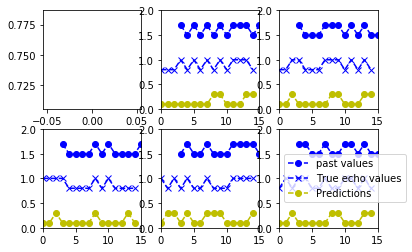

Step 100 Loss 0.5049028


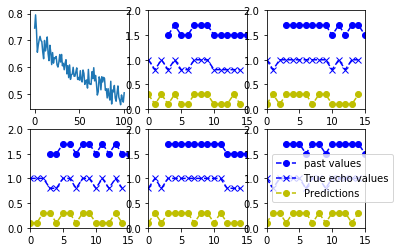

Step 200 Loss 0.39046797


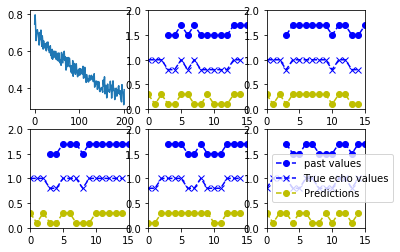

Step 300 Loss 0.283154


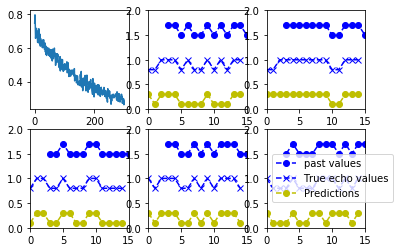

Step 400 Loss 0.2489255


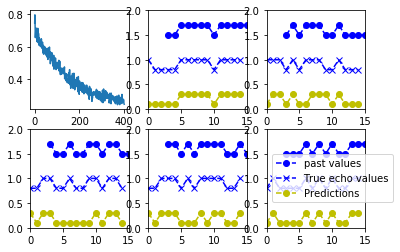

Step 500 Loss 0.22550449


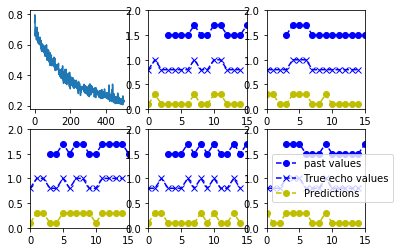

Step 600 Loss 0.20890804


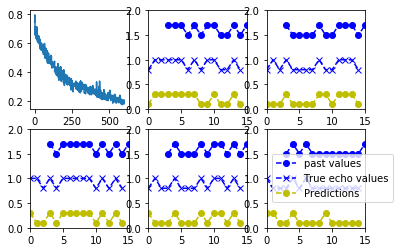

New data, epoch 1
Step 0 Loss 0.3525629


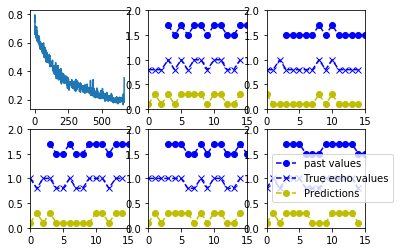

Step 100 Loss 0.18849126


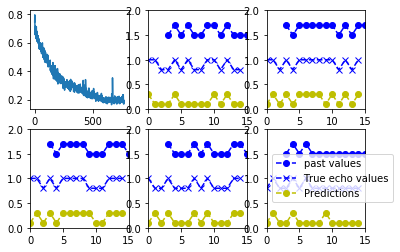

Step 200 Loss 0.18508396


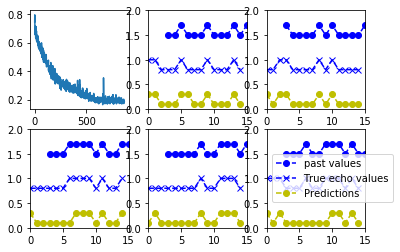

Step 300 Loss 0.18813436


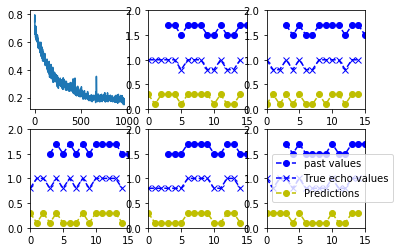

Step 400 Loss 0.15435295


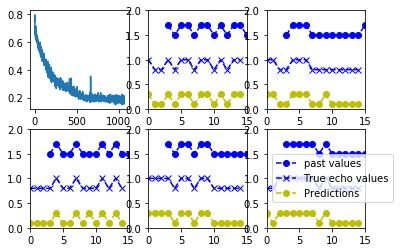

Step 500 Loss 0.17025909


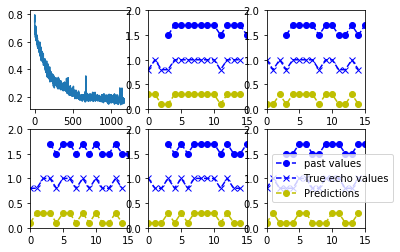

Step 600 Loss 0.1777654


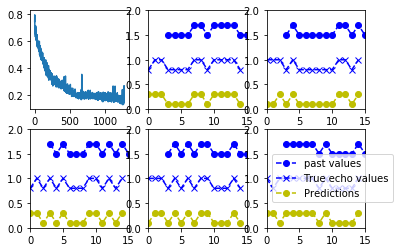

New data, epoch 2
Step 0 Loss 0.18260288


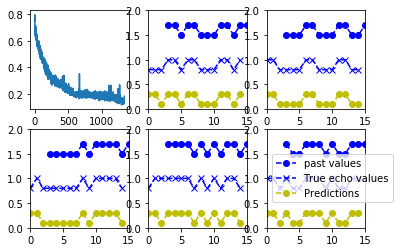

Step 100 Loss 0.12489048


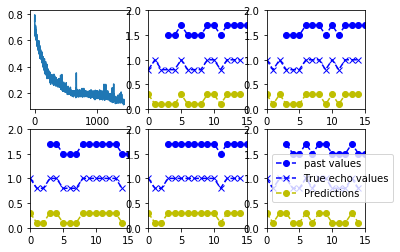

Step 200 Loss 0.12042969


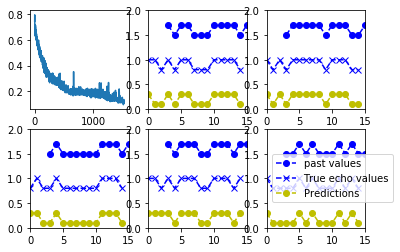

Step 300 Loss 0.10722139


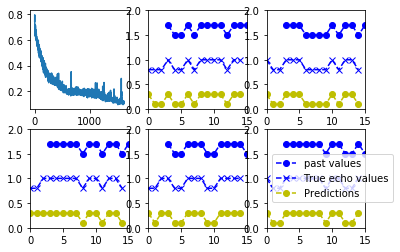

Step 400 Loss 0.10663406


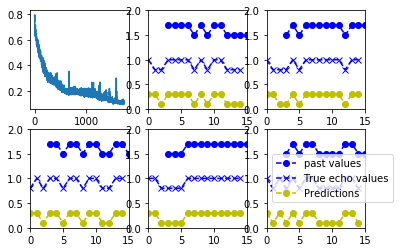

Step 500 Loss 0.10174825


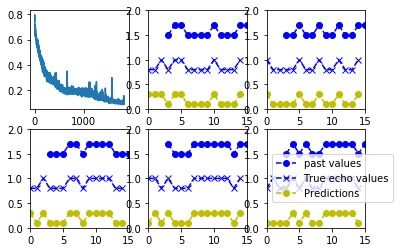

Step 600 Loss 0.104828104


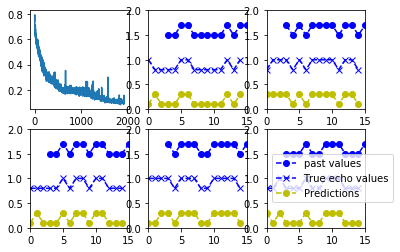

New data, epoch 3
Step 0 Loss 0.20561701


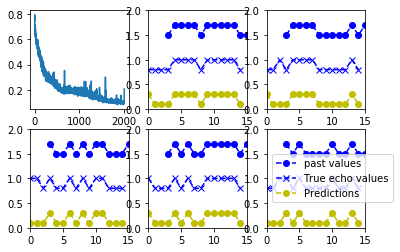

Step 100 Loss 0.109710105


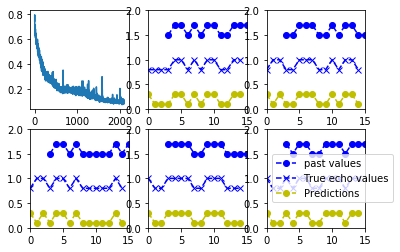

Step 200 Loss 0.10029379


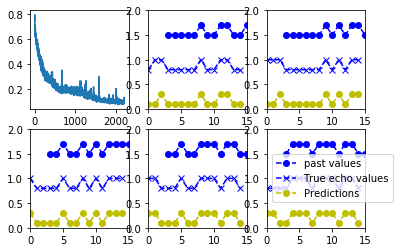

Step 300 Loss 0.11707792


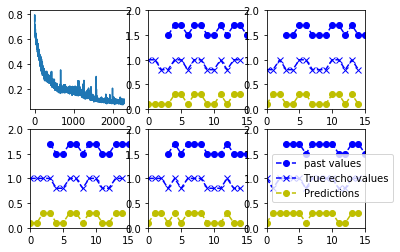

Step 400 Loss 0.09041369


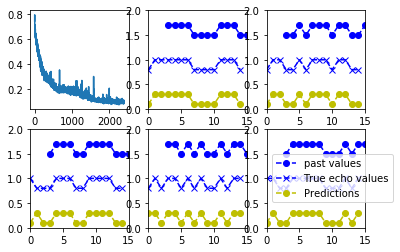

Step 500 Loss 0.08982782


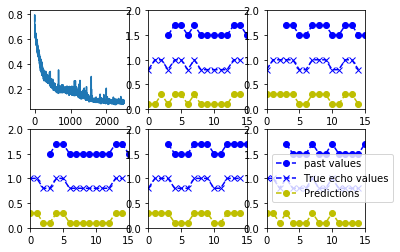

Step 600 Loss 0.11719186


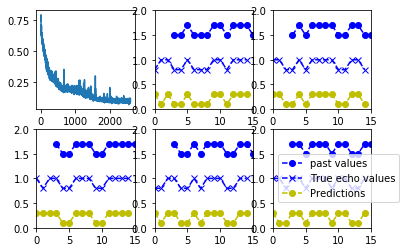

New data, epoch 4
Step 0 Loss 0.18837875


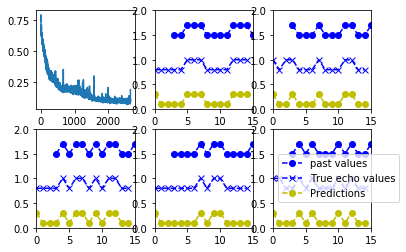

Step 100 Loss 0.08434685


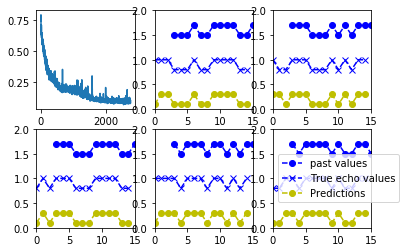

Step 200 Loss 0.07734714


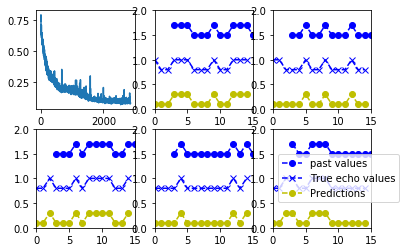

Step 300 Loss 0.08244846


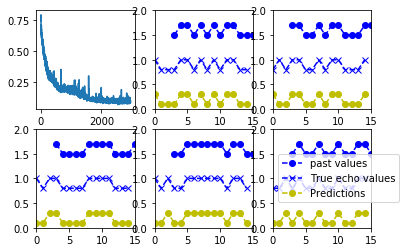

Step 400 Loss 0.089401126


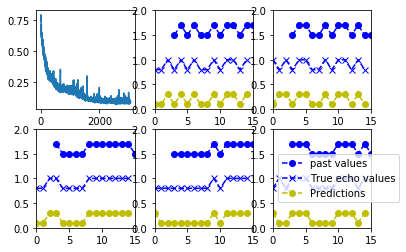

Step 500 Loss 0.08937489


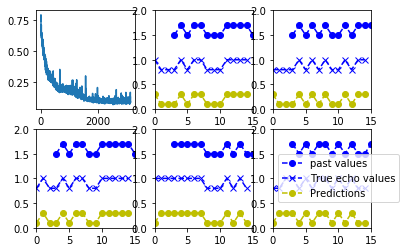

Step 600 Loss 0.104586974


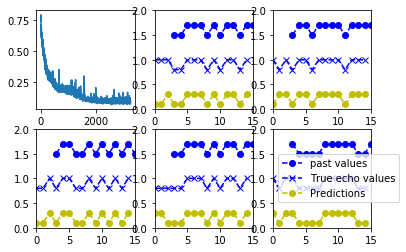

In [5]:
# -*- coding: utf-8 -*-

#############################################实例描述###############################################
##构建一组序列，生成其对应的模拟回声序列。使用Tensorflow创建一个简单循环神经网络拟合这个回声序列###
#####################################################################################################


##################################################################################################
#################第一步：定义参数并生成样本数据###################################################
###################################################################################################



import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 5                      #迭代轮数
total_series_length = 50000         #序列样本数据长度
truncated_backprop_length = 15      #测试时截取数据长度
state_size = 4                       #中间状态长度
num_classes = 2                     #输出类别个数
echo_step = 3                       #回声步长
batch_size = 5                      #小批量大小
##jisuan计算第一轮可以分为多少批
num_batches = total_series_length//batch_size//truncated_backprop_length  #//为向下取整


# 生成原序列和回声序列数据，回声序列滞后原序列echo_step个步长, 返回原序列和回声序列组成的元组   
def generateData():
    #
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))       #在0 和1 中选择total_series_length个数
    y = np.roll(x, echo_step)                                                  #向右循环移位【1111000】---【0001111】
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))     #5x10000
    y = y.reshape((batch_size, -1))     #5x10000
 
    return (x, y)


    
#########################################################################################################################
################# 第二步：定义占位符处理输入数据   ######################################################################
#########################################################################################################################



# 定义3个占位符， batch_x为原始序列，batch_y为回声序列真实值，init_state为循环节点的初始值。
#batch_x是逐个输入网络的，所以需要将输进去的数据打散，按照时间序列变成15个数组，每个数组有batch_size个元素，进行统一批处理

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])     ##原始序列  5乘15
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])       ##回声序列 作为标签 5乘15
init_state = tf.placeholder(tf.float32, [batch_size, state_size])                            ##循环节点的初始状态值 5乘4

##将batch_x沿axis = 1(列)的轴进行拆分    
#返回一个list 每个元素都是一个数组   [(5,),(5,)....] 一共15个元素，即15个序列

inputs_series = tf.unstack(batchX_placeholder, axis=1)#15个5*1的数组
labels_series = tf.unstack(batchY_placeholder, axis=1)



#################################################################################################################################
##############第三步：定义网络结构###############################################################################################
##################################################################################################################################


current_state = init_state              #存放当前的状态
predictions_series = []                 #存放一个小批量中每个输入样本的预测序列值 每个元素为5x2 共有15个元素
losses =[]                              #存放一个小批量中每个输入样本训练的损失值 每个元素是一个标量，共有15个元素  

#使用一个循环，按照序列逐个输入   
for current_input, labels in zip(inputs_series,labels_series):
#确定形状为batch_size x 1
    current_input = tf.reshape(current_input, [batch_size, 1])
#加入初始状态 ，5 x 1序列值和 5 x 4中间状态 按列连接，得到 5 x 5数组 构成输入数据
    input_and_state_concatenated = tf.concat([current_input, current_state],1) 
 #隐藏层激活函数选择tanh 5x4
    next_state = tf.contrib.layers.fully_connected(input_and_state_concatenated,state_size ,activation_fn=tf.tanh)
    current_state = next_state
     #输出层 激活函数选择None，即直接输出 5x2
    logits =tf.contrib.layers.fully_connected(next_state,num_classes,activation_fn=None)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits)
    losses.append(loss)
   # print (losses)
   #经过softmax计算预测值 5x2  注意这里并不是标签值 这里是one_hot编码 
    predictions = tf.nn.softmax(logits)
    predictions_series.append(predictions)
    

total_loss = tf.reduce_mean(losses)   #求均值
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
#实例化一个优化函数Adagrad，基于0.3的学习率进行梯度优化训练
#接着使用minimize()的操作，里面传入损失节点值loss，再启动一个外层循环，优化器就会按照循环的次数一次次沿着loss最小值的方向优化参数。



#####################################################################################################################################
##################第五步：测试模型及可视化###########################################################################
#####################################################################################################################################

'''
    绘制一个小批量中每一个原序列样本，回声序列样本，预测序列样本图像
    
    args:
        loss_list：list 存放每一个批次训练的代价值 
        predictions_series：list长度为5  存放一个批次中每个输入序列的预测序列值 注意这里每个元素(5x2)都是one_hot编码 
        batchx：当前批次的原序列 5x15
        batchy：当前批次的回声序列 5x15
    '''   

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)   #创建子图 2行3列选择第一个  绘制代价值
    plt.cla()
    plt.plot(loss_list)

    #迭代每一个序列  循环5次
    for batch_series_idx in range(batch_size):
         #获取第batch_series_idx个序列的预测值(one_hot编码) 15x2
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        #转换为标签值 (15,)
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        #绘制第batch_series_idx + 2个子图
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])  #设置x轴 y轴坐标值范围
        left_offset = range(truncated_backprop_length)  #获取原序列x坐标值
        left_offset2 = range(echo_step,truncated_backprop_length+echo_step)#获取回声序列x坐标值 滞后3个步长
        
        label1 = "past values"
        label2 = "True echo values" 
        label3 = "Predictions"      
        plt.plot(left_offset2, batchX[batch_series_idx, :]*0.2+1.5, "o--b", label=label1)  #绘制原序列
        plt.plot(left_offset, batchY[batch_series_idx, :]*0.2+0.8,"x--b", label=label2)    #绘制真实回声序列
        plt.plot(left_offset,  single_output_series*0.2+0.1 , "o--y", label=label3)         #绘制预测回声序列
   # 为了让三个序列看起来更明显，将其缩放0.2，并且调节每个图像的高度。
    plt.legend(loc='best')
    plt.draw()
    plt.pause(0.0001)

    
    
#####################################################################################################################################
##################第四步：训练数据并可视化输出###########################################################################
#####################################################################################################################################

#建立session训练数据
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())#先对模型进行初始化
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []    #list 存放每一小批量的代价值

    #开始迭代每一轮（总共5轮）
    for epoch_idx in range(num_epochs):
        x,y = generateData()    #生成原序列和回声序列数据
        #print (x)
        #print(y)
        _current_state = np.zeros((batch_size, state_size)) #初始化循环节点状态值

        print("New data, epoch", epoch_idx)

         #迭代每一小批量
        for batch_idx in range(num_batches):#50000/ 5 /15=分成多少段
            start_idx = batch_idx * truncated_backprop_length    #计算当前batch的起始索引
            end_idx = start_idx + truncated_backprop_length       #计算当前batch的结束索引

            batchX = x[:,start_idx:end_idx]    #当前批次的原序列值
            batchY = y[:,start_idx:end_idx]     #当前批次的回声序列值

            #开始训练当前批次样本
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                #可视化输出
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show() 